In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy

In [2]:
IMG_HEIGHT = 224
IMG_WIDTH  = 224
IMG_CHANNELS = 3

In [3]:
def read_and_decode(filename, reshape_dims):
  img = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img, channels=IMG_CHANNELS)
  img = tf.image.convert_image_dtype(img, tf.float32)
  return tf.image.resize(img, reshape_dims)

In [4]:
def show_image(filename):
  img = read_and_decode(filename=filename, reshape_dims=[IMG_HEIGHT, IMG_WIDTH])
  plt.imshow(img.numpy())

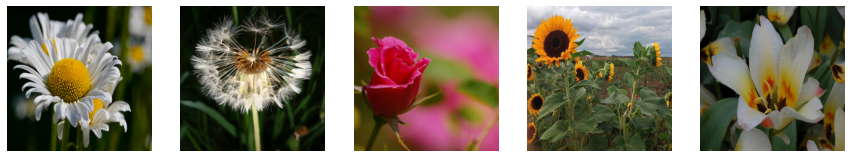

In [5]:
f, ax = plt.subplots(1, 5, figsize=(15, 15))

for idx, filename in enumerate([
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/daisy/754296579_30a9ae018c_n.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/dandelion/3554992110_81d8c9b0bd_m.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/roses/7420699022_60fa574524_m.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/sunflowers/21518663809_3d69f5b995_n.jpg",
  "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/tulips/8713398906_28e59a225a_n.jpg"]):

  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  ax[idx].imshow(img)
  ax[idx].axis("off")

In [6]:
def parse_csvline(csv_row):
  record_defaults = ["path", "flower"]
  filename, label = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  return img, label, filename

In [7]:
dataset = (tf.data.TextLineDataset("gs://cloud-ml-data/img/flower_photos/train_set.csv").map(parse_csvline))
for img, label, filename in dataset.take(3):
  avg = tf.math.reduce_mean(img, axis=[0, 1])
  print(label, avg, filename)

tf.Tensor(b'daisy', shape=(), dtype=string) tf.Tensor([0.3588961  0.36257887 0.26933077], shape=(3,), dtype=float32) tf.Tensor(b'gs://cloud-ml-data/img/flower_photos/daisy/754296579_30a9ae018c_n.jpg', shape=(), dtype=string)
tf.Tensor(b'dandelion', shape=(), dtype=string) tf.Tensor([0.32278517 0.32278517 0.32278517], shape=(3,), dtype=float32) tf.Tensor(b'gs://cloud-ml-data/img/flower_photos/dandelion/18089878729_907ed2c7cd_m.jpg', shape=(), dtype=string)
tf.Tensor(b'dandelion', shape=(), dtype=string) tf.Tensor([0.20397592 0.13298093 0.07217225], shape=(3,), dtype=float32) tf.Tensor(b'gs://cloud-ml-data/img/flower_photos/dandelion/284497199_93a01f48f6.jpg', shape=(), dtype=string)


In [8]:
def parse_csv(csv_row):
  record_defaults = ["path", "flower"]
  filename, label_string = tf.io.decode_csv(csv_row, record_defaults)
  img = read_and_decode(filename, [IMG_HEIGHT, IMG_WIDTH])
  label = tf.argmax(tf.math.equal(CLASS_NAMES, label_string))
  return img, label

In [9]:
CLASS_NAMES = [item.numpy().decode('utf-8')
              for item in tf.strings.regex_replace(tf.io.gfile.glob("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/*"),
                 "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/", "")]

CLASS_NAMES = [item for item in CLASS_NAMES if item.find(".") == -1]
print("These are the available class: ", CLASS_NAMES)

These are the available class:  ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [11]:
train_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv")
    .map(parse_csv)).batch(10)

eval_dataset = (tf.data.TextLineDataset(
    "gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv")
    .map(parse_csv)).batch(10)

In [12]:
model = tf.keras.Sequential([
                             tf.keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)), 
                             tf.keras.layers.Dense(len(CLASS_NAMES),activation='softmax')
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy']
)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 150528)            0         
_________________________________________________________________
dense (Dense)                (None, 5)                 752645    
Total params: 752,645
Trainable params: 752,645
Non-trainable params: 0
_________________________________________________________________


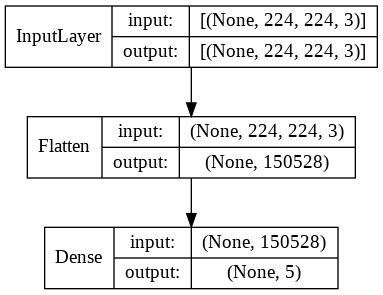

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [16]:
history = model.fit(train_dataset, validation_data=eval_dataset, epochs=10)

Epoch 1/10
330/330 [==============================] - 136s 404ms/step - loss: 17.4682 - accuracy: 0.3415 - val_loss: 14.0748 - val_accuracy: 0.4027
Epoch 2/10
330/330 [==============================] - 111s 336ms/step - loss: 14.5909 - accuracy: 0.4061 - val_loss: 25.1610 - val_accuracy: 0.4027
Epoch 3/10
330/330 [==============================] - 90s 272ms/step - loss: 14.1620 - accuracy: 0.4488 - val_loss: 18.1211 - val_accuracy: 0.4270
Epoch 4/10
330/330 [==============================] - 89s 269ms/step - loss: 11.7187 - accuracy: 0.4970 - val_loss: 29.3635 - val_accuracy: 0.3892
Epoch 5/10
330/330 [==============================] - 95s 288ms/step - loss: 11.4053 - accuracy: 0.5167 - val_loss: 17.2247 - val_accuracy: 0.3649
Epoch 6/10
330/330 [==============================] - 88s 266ms/step - loss: 14.3802 - accuracy: 0.5027 - val_loss: 13.7068 - val_accuracy: 0.4568
Epoch 7/10
330/330 [==============================] - 88s 267ms/step - loss: 12.1153 - accuracy: 0.5497 - val_loss: 

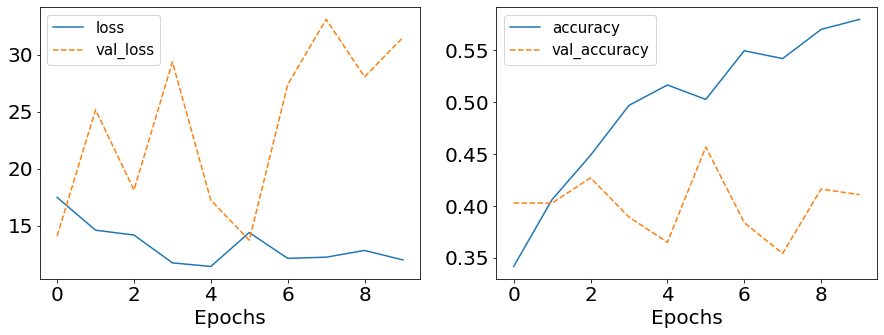

In [19]:
import matplotlib 
matplotlib.rcParams.update({'font.size': 20})

def training_plot(metrics, history):
  f, ax = plt.subplots(1, len(metrics), figsize=(15, 5))

  for idx, metric in enumerate(metrics):
    ax[idx].plot(history.history[metric])
    ax[idx].plot(history.history['val_' + metric], ls='dashed')

    ax[idx].set_xlabel("Epochs")    
    ax[idx].legend([metric, 'val_'+metric], fontsize=15)

training_plot(['loss', 'accuracy'], history)

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

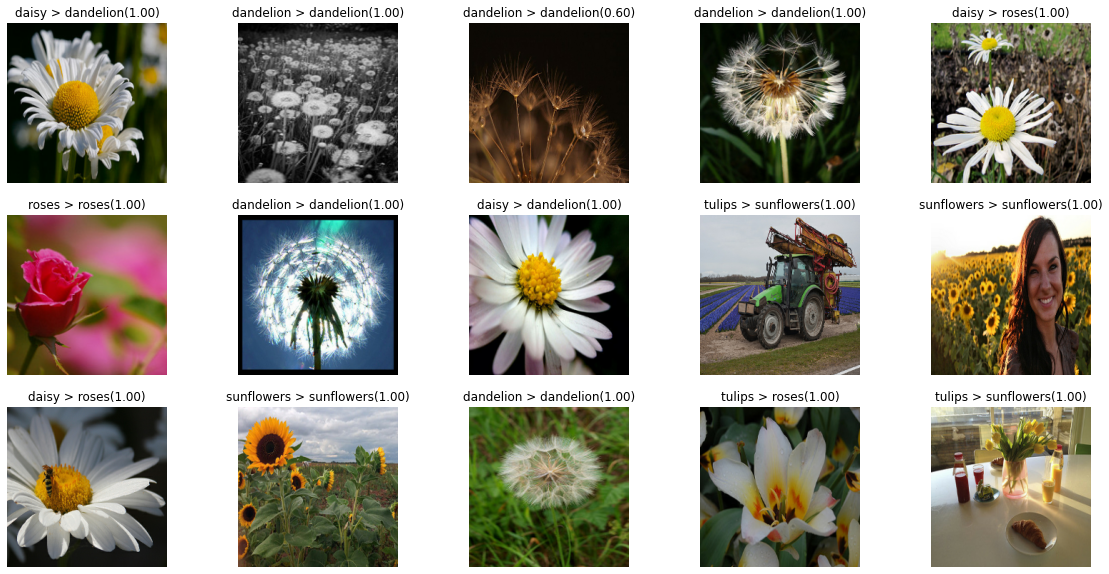

In [28]:
def plot_predictions(filename):
  matplotlib.rcParams.update({'font.size': 10})

  f, ax = plt.subplots(3, 5, figsize=(20, 10))

  dataset = (tf.data.TextLineDataset(filename).map(parse_csv))

  for idx, (img, label) in enumerate(dataset.take(15)):
    ax[idx//5, idx%5].imshow((img.numpy()))

    batch_image = tf.reshape(img, [1, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS])
    batch_pred = model.predict(batch_image)

    pred = batch_pred[0]
    pred_label_index = tf.math.argmax(pred).numpy()
    pred_label = CLASS_NAMES[pred_label_index]
    prob = pred[pred_label_index]

    label = CLASS_NAMES[label.numpy()]

    ax[idx//5, idx%5].set_title('{} > {}({:.2f})'.format(label, pred_label, prob))
    ax[idx//5, idx%5].axis('off')

plot_predictions("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/train_set.csv")

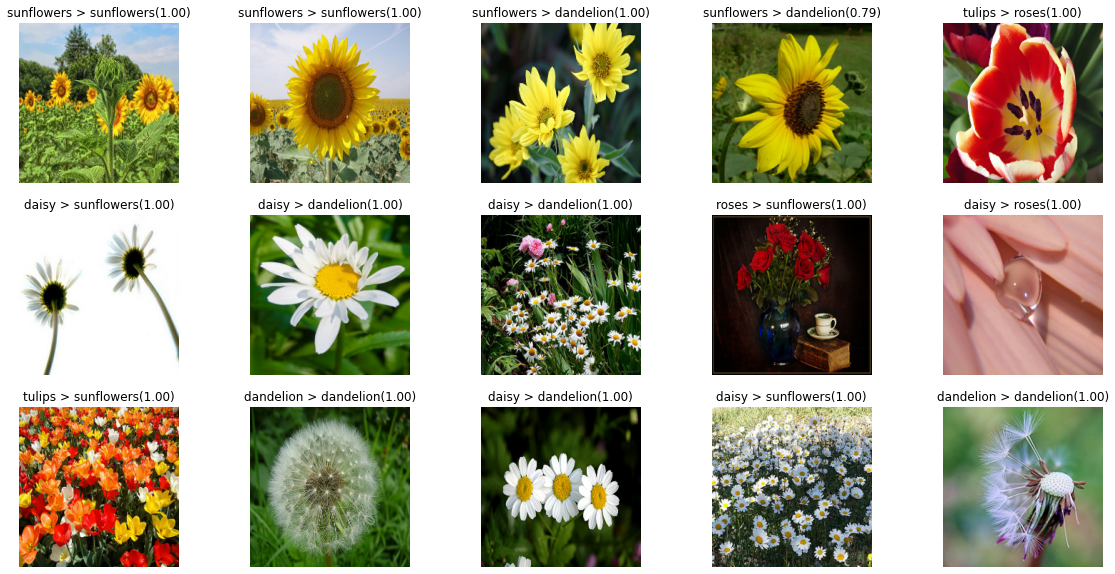

In [ ]:
plot_predictions("gs://practical-ml-vision-book/flowers_5_jpeg/flower_photos/eval_set.csv")